Model version 3 with enhnacement = Fine-tune the top layers of the model

In [5]:
import os
import numpy as np
from PIL import Image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model, load_model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Directory containing the images
DATA_DIR = '/Users/vaidehipatel/Documents/Course Sem 2/GWAR/Rotated_Plants_Dataset_copy'

# Function to load and preprocess images
def preprocess_image(img_path, target_size=(224, 224)):
    try:
        img = Image.open(img_path).convert('RGB')  # Convert to RGB
        img = img.resize(target_size)
        img_array = np.array(img)
        return img_array
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

# Load and preprocess images
images = []
labels = []
for cls in os.listdir(DATA_DIR):
    class_dir = os.path.join(DATA_DIR, cls)
    if os.path.isdir(class_dir):  # Check if it's a directory
        # Iterate over images in the class folder
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img_array = preprocess_image(img_path)
            if img_array is not None:
                images.append(img_array)
                labels.append(cls)

# Convert labels to numerical format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert numerical labels to one-hot encoded format
NUM_CLASSES = len(set(labels))
labels_array = np.array(labels_encoded)
labels_one_hot = to_categorical(labels_array, num_classes=NUM_CLASSES)

# Convert images and labels to numpy arrays
images_array = np.array(images)

# Split the data into training, testing, and validation sets
train_images, test_images, train_labels, test_labels = train_test_split(images_array, labels_one_hot, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Load MobileNetV1 pre-trained on ImageNet without the top classification layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze lower layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Add custom classification layers on top of MobileNetV1
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tune the top layers of the model
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, batch_size=32, epochs=10, validation_data=(val_images, val_labels))

# Save the model
model.save('plant_classification_model.h5')

# Make predictions on all sets
train_pred = model.predict(train_images)
val_pred = model.predict(val_images)
test_pred = model.predict(test_images)

# Calculate metrics for each set
train_accuracy = accuracy_score(np.argmax(train_labels, axis=1), np.argmax(train_pred, axis=1))

val_accuracy = accuracy_score(np.argmax(val_labels, axis=1), np.argmax(val_pred, axis=1))

test_accuracy = accuracy_score(np.argmax(test_labels, axis=1), np.argmax(test_pred, axis=1))
test_precision = precision_score(np.argmax(test_labels, axis=1), np.argmax(test_pred, axis=1), average='weighted')
test_recall = recall_score(np.argmax(test_labels, axis=1), np.argmax(test_pred, axis=1), average='weighted')
test_f1 = f1_score(np.argmax(test_labels, axis=1), np.argmax(test_pred, axis=1), average='weighted')

# Print evaluation metrics for each set
print("Training Metrics:")
print("Accuracy:", train_accuracy)


print("Validation Metrics:")
print("Accuracy:", val_accuracy)


print("Test Metrics:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)

# Generate classification report for the test set
test_classification_report = classification_report(np.argmax(test_labels, axis=1), np.argmax(test_pred, axis=1), target_names=label_encoder.classes_)

# Print classification report
print("Test Classification Report:")
print(test_classification_report)


Error loading image /Users/vaidehipatel/Documents/Course Sem 2/GWAR/Rotated_Plants_Dataset_copy/Rosary_Pea/.DS_Store: cannot identify image file '/Users/vaidehipatel/Documents/Course Sem 2/GWAR/Rotated_Plants_Dataset_copy/Rosary_Pea/.DS_Store'
Error loading image /Users/vaidehipatel/Documents/Course Sem 2/GWAR/Rotated_Plants_Dataset_copy/Cicuta_/.DS_Store: cannot identify image file '/Users/vaidehipatel/Documents/Course Sem 2/GWAR/Rotated_Plants_Dataset_copy/Cicuta_/.DS_Store'
Error loading image /Users/vaidehipatel/Documents/Course Sem 2/GWAR/Rotated_Plants_Dataset_copy/English_Yew/.DS_Store: cannot identify image file '/Users/vaidehipatel/Documents/Course Sem 2/GWAR/Rotated_Plants_Dataset_copy/English_Yew/.DS_Store'
Error loading image /Users/vaidehipatel/Documents/Course Sem 2/GWAR/Rotated_Plants_Dataset_copy/.DS_Store/right: [Errno 21] Is a directory: '/Users/vaidehipatel/Documents/Course Sem 2/GWAR/Rotated_Plants_Dataset_copy/.DS_Store/right'
Error loading image /Users/vaidehipate

508/508 ━━━━━━━━━━━━━━━━━━━━ 106s 209ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 26s 208ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 206ms/step
Training Metrics:
Accuracy: 0.9394704433497537
Validation Metrics:
Accuracy: 0.8519704433497537
Test Metrics:
Accuracy: 0.8550039401103231
Precision: 0.8744073227107666
Recall: 0.8550039401103231
F1 Score: 0.8555832407682554
Test Classification Report:
                    precision    recall  f1-score   support

     Angel_Trumpet       0.77      0.92      0.84       600
       Castor_Bean       0.78      0.94      0.85       417
           Cicuta_       1.00      0.92      0.96       521
           Datura_       0.92      0.59      0.72       573
       English_Yew       0.78      0.92      0.84       605
         Foxglove_       0.96      0.88      0.92       643
Lily_of_the_Valley       0.92      0.88      0.90       590
       Manchineel_       0.87      0.79      0.83       291
        Rosary_Pea       0.56      0.91      0.70       217
   White_Snak

### Confusion Matrix

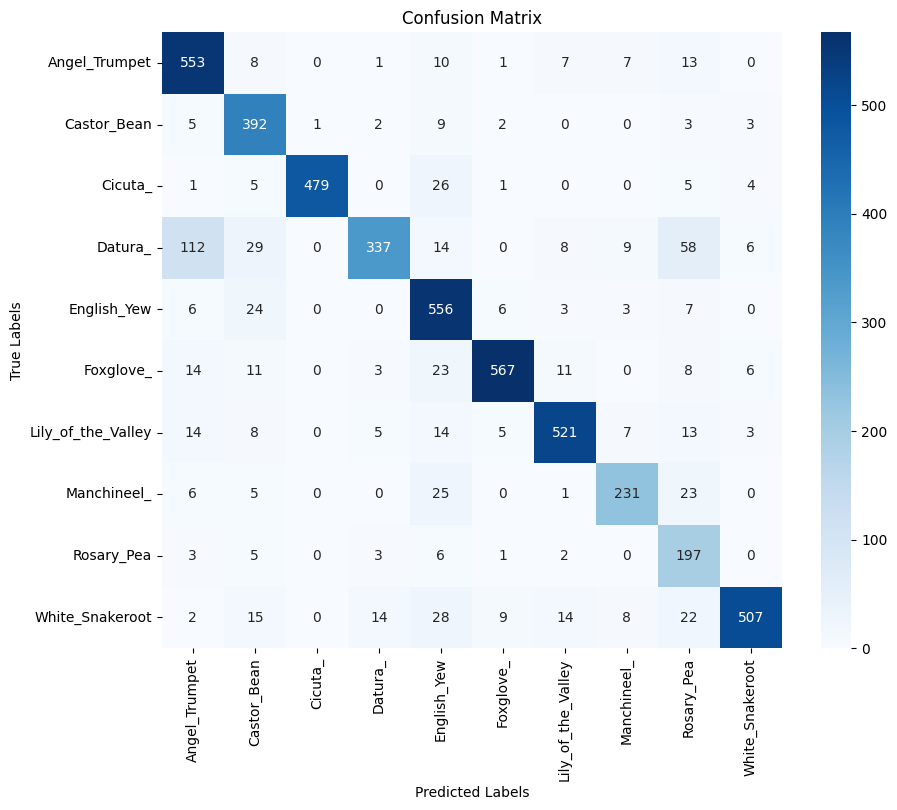

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(test_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


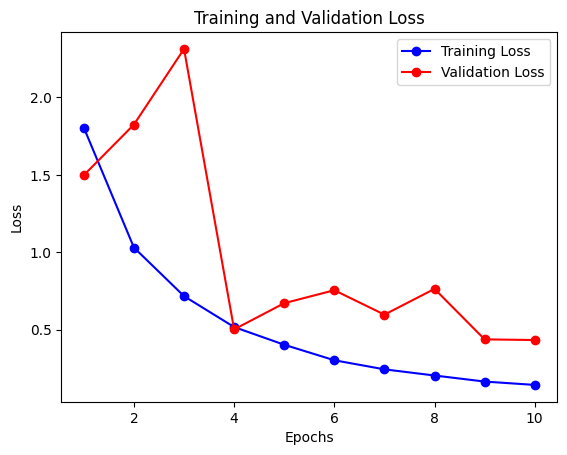

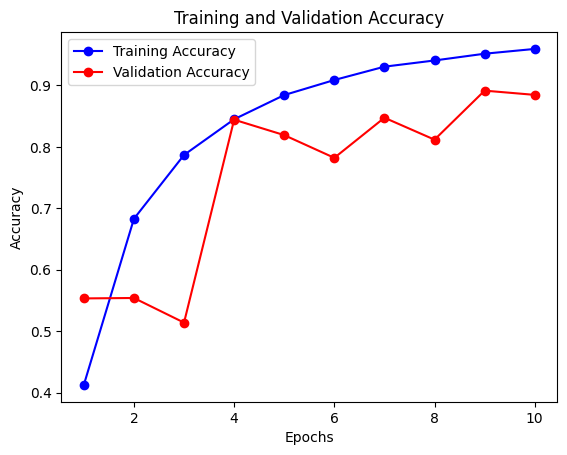

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Training and Validation Loss over Epochs
epochs = range(1, 11)  # Assuming 10 epochs
train_loss = [1.8047, 1.0301, 0.7164, 0.5168, 0.4024, 0.3022, 0.2435, 0.2037, 0.1646, 0.1429]
val_loss = [1.4977, 1.8246, 2.3132, 0.5016, 0.6709, 0.7546, 0.5968, 0.7632, 0.4371, 0.4328]

plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training and Validation Accuracy over Epochs
train_acc = [0.4124, 0.6828, 0.7867, 0.8448, 0.8842, 0.9087, 0.9304, 0.9405, 0.9515, 0.9593]
val_acc = [0.5532, 0.5539, 0.5138, 0.8441, 0.8190, 0.7820, 0.8473, 0.8116, 0.8914, 0.8845]

plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




### Training and Validation loss and accuracy plot

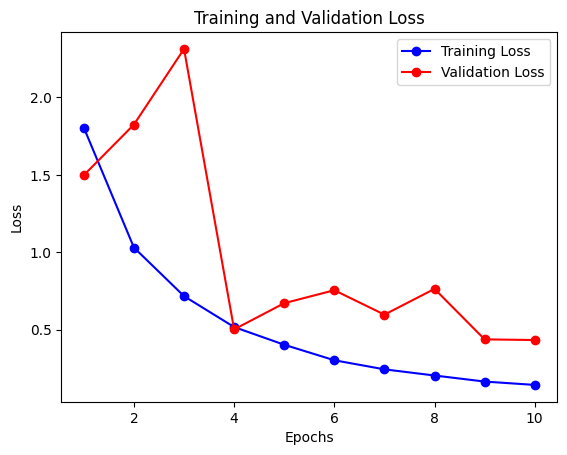

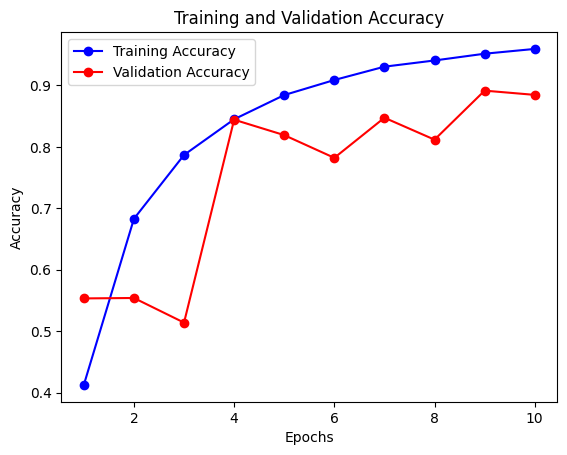

In [12]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
